In [1]:
import json
import pandas
import re
import string
import pickle
import time
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import scipy.cluster.hierarchy as sch

from sys import stdout
from collections import defaultdict, Counter
from scipy import stats
from operator import itemgetter
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist,squareform
from datetime import datetime, timedelta
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration

In [2]:
def createDataFrame(path):
    return pd.read_excel(path,
    header=0,
    index_col= 0,
    keep_default_na=True)

def pearsonr_pval(x,y):
    return format(stats.pearsonr(x,y)[1],'f')

def calculate_pvalues(df):
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if c == r:
                df_corr = df[[r]].dropna()
            else:
                df_corr = df[[r,c]].dropna()
            pvalues[r][c] = stats.spearmanr(df_corr[r], df_corr[c])[1]
    return pvalues

def flattenList(alist):
    flat_list = []
    for sublist in alist:
        if sublist is None:
            flat_list.append(None)
        else: 
            tempList = []
            for item in sublist:    
                tempList.append(item[0])
            flat_list.append(tempList)
    return flat_list

def listToDict(clist):
    dictList = []
    for templist in clist:
        newdict = {}
        for col in templist:
            newdict[col[0]] = col[1]
        dictList.append(newdict)
    return dictList

def ICGConversion(clist):
    listDict = listToDict(clist)
    df2 = pd.DataFrame
    dFList = []
    for i, tempDict in enumerate(listDict):
        dFList.append(df2.from_records(tempDict, index = [i]))
    df3 = pd.concat(dFList)
    return df3

def corrAnalysis(df1, df2):
    newList = []
    coeffmat = np.zeros((df1.shape[1], df2.shape[1]))
    pvalmat = np.zeros((df1.shape[1], df2.shape[1]))

    for i in range(df1.shape[1]):    
        for j in range(df2.shape[1]):        
            corrtest = stats.spearmanr(df1[df1.columns[i]], df2[df2.columns[j]])  

            coeffmat[i,j] = corrtest[0]
            pvalmat[i,j] = corrtest[1]
    newList.append(pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns))
    newList.append(pd.DataFrame(pvalmat, columns=df2.columns, index=df1.columns))
    return newList

def returnValueList(clist):
    return clist[1]

def checkIfDuplicates_1(listOfElems):
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True


In [3]:
#Loads Dataframes from pickle
pickle_off = open("..\\ProcessedData\\B0.pickle","rb")
b0ev = pickle.load(pickle_off)
b0rv = pickle.load(pickle_off)
b0pf = pickle.load(pickle_off)
pickle_off.close()

pickle_off = open("..\\ProcessedData\\B1.pickle","rb")
b1ev = pickle.load(pickle_off)
b1rv = pickle.load(pickle_off)
b1pf = pickle.load(pickle_off)
pickle_off.close()

b0ev['Timestamp'] = pd.to_datetime(b0ev['Timestamp'])
b1ev['Timestamp'] = pd.to_datetime(b1ev['Timestamp'])

In [4]:
# Profile Data Analysis
#Transforms Conceptlists into probability Dummylist
B0ICGconv = ICGConversion(b0ev['ICG'])
B1ICGconv = ICGConversion(b1ev['ICG'])

#Dummy Variables 1-0
B0CG_dummy = B0ICGconv.notnull().astype(int)
B1CG_dummy = B1ICGconv.notnull().astype(int)

#Counts occurences of dummy variables
b0counts = B0CG_dummy.replace(0,np.nan).count().sort_values(ascending = False)
b1counts = B1CG_dummy.replace(0,np.nan).count().sort_values(ascending = False)

#
b0counts.describe()
b1counts.describe()

b0ev['CaptionPolarity'].describe()
b0ev['CaptionSubjectivity'].describe()
b1ev['CaptionPolarity'].describe()
b1ev['CaptionSubjectivity'].describe()


count    272.000000
mean       0.441445
std        0.266695
min        0.000000
25%        0.290404
50%        0.466667
75%        0.609063
max        1.000000
Name: CaptionSubjectivity, dtype: float64

In [5]:
profiles = pd.concat([b0pf, b1pf])
profiles.reset_index(drop=True, inplace=True)
profiles = profiles.drop(columns = ['name','time'])
profiles['FirstPost'] = b0ev['Timestamp'][745].strftime(format = '%H:%M %d-%m-%Y')
profiles['FirstPost'][1] = b1ev['Timestamp'][271].strftime(format = '%H:%M %d-%m-%Y')
profiles = profiles.rename(columns = {'time':'Timestamp', 'followers':'Followers', 'following':'Following', 'posts':'Posts'})

<ipython-input-5-5202ab84cd12>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles['FirstPost'][1] = b1ev['Timestamp'][271].strftime(format = '%H:%M %d-%m-%Y')


In [7]:
profiles['LastPost'] = b0ev['Timestamp'][0].strftime(format = '%H:%M %d-%m-%Y')
profiles['LastPost'][1] = b1ev['Timestamp'][3].strftime(format = '%H:%M %d-%m-%Y')
profiles

<ipython-input-7-86004dbbda61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles['LastPost'][1] = b1ev['Timestamp'][3].strftime(format = '%H:%M %d-%m-%Y')


,Followers,Following,Posts,FirstPost,LastPost
0,69744,39,746,12:54 09-04-2018,14:41 13-09-2020
1,89662,54,272,15:28 10-01-2014,16:00 21-09-2020


In [8]:
mostOccuredConcepts = pd.DataFrame(b1counts.head(20), columns = ['Occurence'])
mostOccuredConcepts0 = pd.DataFrame(b0counts.head(20), columns = ['Occurence'])


In [9]:
# mostOccuredConcepts0.T.reset_index().drop(columns = "index")
mostOccuredConcepts0.T.index = np.arange(1, len(mostOccuredConcepts0.T) + 1)
mostOccuredConcepts0.T

,nature,no person,desktop,travel,landscape,water,sky,summer,sea,winter,snow,business,outdoors,ocean,disjunct,isolated,beach,cold,ice,mountain
Occurence,485,474,291,286,267,228,217,188,168,167,152,149,145,139,132,121,114,111,105,102


In [20]:
#Prepare merged Dummy tables for clustering

B0CG_dummy['Identifier'] = 0
B1CG_dummy['Identifier'] = 1

concDummy = pd.concat([B0CG_dummy, B1CG_dummy])
concDummyId = pd.concat([B0CG_dummy, B1CG_dummy])
concDummyId.reset_index(drop=True, inplace=True)
concDummy.reset_index(drop=True, inplace=True)
concDummy = concDummy.loc[:,'beach':].fillna(0).astype(int)
concDummyId = concDummyId.fillna(0).astype(int)

In [21]:
# Remove single occurences
concDummyCounts = concDummy.replace(0,np.nan).count().sort_values(ascending = False)
to_del = concDummyCounts.where(concDummyCounts <=2).dropna().index.values
concDummy.drop(to_del, axis=1, inplace=True)
concDummyId.drop(to_del, axis=1, inplace=True)
concDummy = concDummy.drop(columns = "Identifier").T

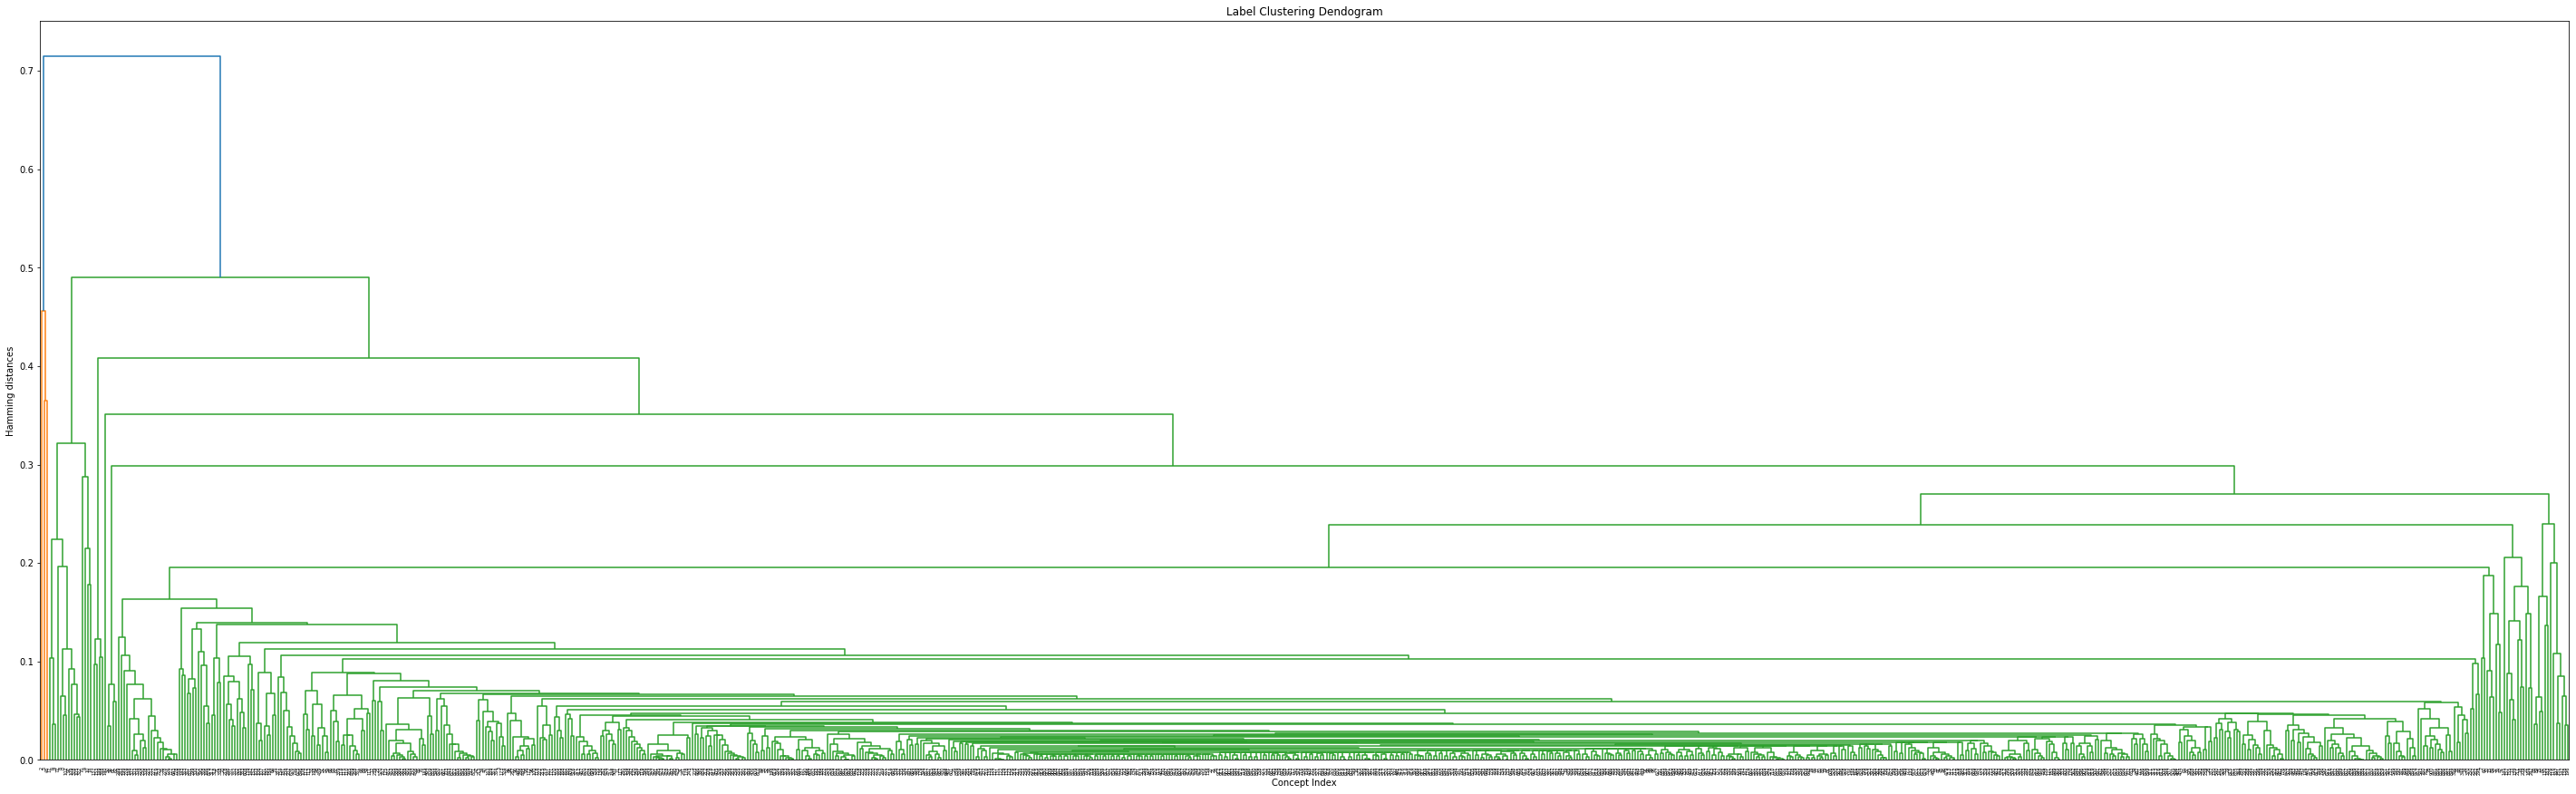

In [25]:
# Shows clustering post Groups bases on concepts and best cut off points through Dendogram
plt.figure(figsize=(50,15))
dendrogram = sch.dendrogram(sch.linkage(concDummy,metric = "hamming", method  = "complete"))

plt.title('Label Clustering Dendogram')
plt.xlabel('Concept Index')
plt.ylabel('Hamming distances')
plt.show()
axis=1

In [26]:
# Agglomerative CLustering with specified parameters
hc = AgglomerativeClustering(n_clusters = 24, affinity = 'hamming', linkage ='complete')
check_y_hc=hc.fit_predict(concDummy)


In [27]:
#Show Conceptcount of groups and assignement 
df5 = pd.DataFrame(columns = ['Concept', 'Group'])
df5['Concept'] = concDummy.index.values
df5['Group'] = check_y_hc
print("Assignement Table")
print(df5)

np.set_printoptions(threshold=sys.maxsize)
occ = Counter(check_y_hc)
print("Occurence Table")
print(occ.most_common())


Assignement Table
           Concept  Group
0            beach     11
1           desert      0
2          desktop     15
3              dry      0
4        landscape     14
..             ...    ...
912        balloon      0
913  entertainment      0
914         signal      0
915           wait      0
916      newspaper      0

[917 rows x 2 columns]
Occurence Table
[(0, 835), (5, 22), (11, 8), (4, 7), (1, 6), (12, 6), (8, 4), (22, 4), (3, 4), (6, 3), (2, 3), (9, 2), (10, 2), (15, 1), (14, 1), (23, 1), (20, 1), (18, 1), (19, 1), (21, 1), (17, 1), (13, 1), (16, 1), (7, 1)]


In [31]:
df5.query("Group == 9")

,Concept,Group
7,rock,9
60,mountain,9


In [29]:
#Agglomerate Features with specified parameters
hc = FeatureAgglomeration(n_clusters = 24, affinity = 'hamming', linkage ='complete',pooling_func = np.sum)
clusteredy_hc=hc.fit_transform(concDummy.T)

df = pd.DataFrame.from_records(clusteredy_hc)
num_cols = len(list(df))
rng = range(1, num_cols+1)
new_cols = ['G' + str(i) for i in rng]
df.columns = new_cols[:num_cols]
y_hc = df
y_hc

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G15,G16,G17,G18,G19,G20,G21,G22,G23,G24
0,5,1,0,0,1,0,3,0,0,1,...,1,1,0,0,1,0,1,0,0,1
1,10,1,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,12,3,1,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,10,0,0,0,0,0,3,0,4,1,...,1,0,0,0,0,0,0,0,0,1
4,9,0,0,0,0,0,0,0,1,2,...,1,0,0,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,12,0,0,4,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1014,5,0,0,4,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1015,13,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
1016,9,0,1,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#Count occurences of Concept Groups in pictures
gcounts = df.copy()
gcounts[gcounts > 0] = 1
gcounts.replace(0,np.nan).count().sort_values(ascending = False)

G1     1015
G20     544
G24     514
G19     334
G16     308
G4      307
G15     289
G6      254
G7      246
G5      244
G2      243
G21     237
G22     222
G18     216
G12     210
G3      202
G9      200
G14     198
G13     193
G11     193
G10     156
G8      140
G17     131
G23     130
dtype: int64

In [32]:
#Preparing multivariate DataFrame
b0rv['Identifier'] = 0
b1rv['Identifier'] = 1
responseConc = pd.concat([b0rv, b1rv])
responseConc.reset_index(drop=True, inplace=True)
col = responseConc.pop("Identifier")
responseConc.insert(0, col.name, col)

b0merge = b0ev.loc[:,'Timestamp':'CaptionWordCount']
b1merge = b1ev.loc[:,'Timestamp':'CaptionWordCount']
b0merge['Identifier'] = 0
b1merge['Identifier'] = 1
eMergeConc = pd.concat([b0merge, b1merge])
eMergeConc.reset_index(drop=True, inplace=True)
eMergeConc['Hour'] = eMergeConc['Timestamp'].dt.hour
eMergeConc['Weekday'] = eMergeConc['Timestamp'].dt.weekday
col = eMergeConc.pop("Identifier")
eMergeConc.insert(0, col.name, col)
multiVariateBase = eMergeConc.join( pd.DataFrame(data=pd.DataFrame(y_hc)))
multiVariateBase = responseConc.loc[:,'Likes':].join(multiVariateBase,lsuffix='Identifier')
multiVariateBase['Video'] = multiVariateBase['Video'].astype(int)
multiVariateBase['CommentsEnabled'] = multiVariateBase['CommentsEnabled'].astype(int)
try: 
    multiVariateBase = multiVariateBase.drop('Timestamp', axis = 1)
except KeyError:
    print('Error')

multiVariateBase = multiVariateBase.fillna(0)

In [34]:
#Count hour occurence
occ = Counter(multiVariateBase['Hour'])
occ

Counter({14: 226,
         13: 103,
         15: 203,
         16: 198,
         17: 90,
         18: 41,
         12: 63,
         19: 28,
         11: 7,
         8: 2,
         10: 3,
         21: 19,
         20: 20,
         9: 2,
         22: 7,
         23: 5,
         1: 1})

In [35]:
#3 Hour Timebins
cut_labels = ['0-3','3-6','6-9','9-12','12-15','15-18','18-21','21-24']
bins = np.array([0,3,6,9,12,15,18,21,24])
df2 = pd.DataFrame()
df2["bucket"] = pd.cut(multiVariateBase['Hour'], bins, labels=cut_labels)
multiVariateBase['Hour'] = df2["bucket"]


In [36]:
#Rename Columns
multiVariateBase = multiVariateBase.rename(columns = {'totalCommentPolarity' : 'AvgCommentPolarity', 'totalCommentSubjectivity':'AvgCommentSubjectivity', 'CommentAvgWordCount':'AvgCommentWordCount','Hour':'TimeBins' })

In [37]:
#Adding Timebins and Weekdays to Multivariate DataFrame
hourDummy = pd.get_dummies(multiVariateBase['TimeBins'])
weekdayDummy = pd.get_dummies(multiVariateBase['Weekday'])
weekdayDummy = weekdayDummy.rename(columns = {0:'Monday',1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5: 'Saturday', 6:'Sunday'})

hourDummy.columns = hourDummy.columns.astype(str)

multiVariateBase = multiVariateBase.drop(columns=['TimeBins','Weekday'])
multiVariateBase = multiVariateBase.join( pd.DataFrame(hourDummy))
multiVariateBase = multiVariateBase.join( pd.DataFrame(weekdayDummy))
multiVariateBase = multiVariateBase.fillna(0)

In [42]:
multiVariateBase

,Likes,Comments,AvgCommentWordCount,AvgCommentPolarity,AvgCommentSubjectivity,Identifier,CommentsEnabled,Video,CaptionPolarity,CaptionSubjectivity,...,15-18,18-21,21-24,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,607,2,0.00,0.000000,0.000000,0,1,0,0.002500,0.512500,...,0,0,0,0,0,0,0,0,0,1
1,437,2,2.00,0.000000,0.000000,0,1,0,0.115909,0.319223,...,0,0,0,0,0,1,0,0,0,0
2,610,3,2.33,0.000000,0.000000,0,1,0,0.116667,0.395833,...,0,0,0,1,0,0,0,0,0,0
3,785,6,11.17,0.435714,0.668571,0,1,0,0.166667,0.378704,...,0,0,0,0,0,0,0,1,0,0
4,713,4,7.50,-0.062500,0.437500,0,1,0,0.196154,0.370513,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,107,27,18.92,0.084746,0.475079,1,1,0,0.266136,0.446288,...,0,1,0,0,1,0,0,0,0,0
1014,103,4,3.50,1.000000,1.000000,1,1,0,0.259949,0.536735,...,1,0,0,0,1,0,0,0,0,0
1015,116,5,6.00,0.291667,0.450000,1,1,0,0.177083,0.477083,...,1,0,0,1,0,0,0,0,0,0
1016,101,7,44.80,0.131250,0.279167,1,1,0,0.446875,0.856250,...,0,1,0,1,0,0,0,0,0,0


In [43]:
pickling_on = open("..\\ProcessedData\\MultiVariateBase.pickle","wb")
pickle.dump(multiVariateBase, pickling_on)
pickle.dump(concDummyId, pickling_on)
pickle.dump(df5,pickling_on)
pickling_on.close()